In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect

%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/72_8.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

209.776857138


In [4]:
t0_df_72 = pd.read_csv('72_8_t0.csv')

In [5]:
def Process(Event):
    mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
    #print mesh
    return mesh
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

7.71161007881


In [6]:
def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

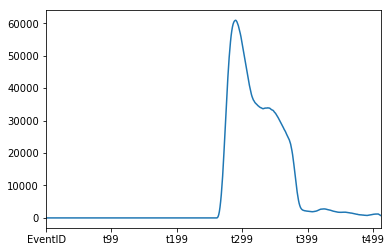

In [7]:
convol_df.iloc[1].T.plot()

In [8]:
t0_df_72[t0_df_72['t0']>420]
t0_df_72.columns = ['EventID','Edge']

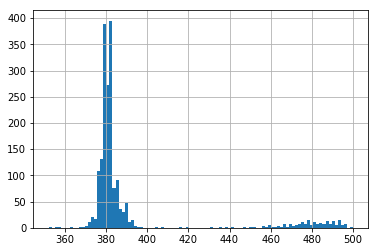

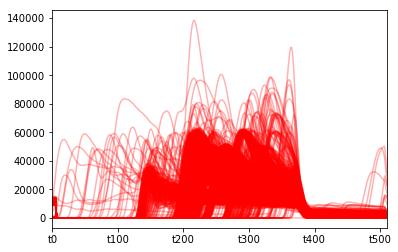

In [9]:
train_df = pd.merge(convol_df,t0_df_72,on='EventID')

def generate(r):
    pass

train_df.groupby('EventID').apply(generate)
train_df['Edge'].hist(bins=100)
plt.figure()
train_df[(train_df['Edge']<400)].iloc[:,1:-1].T.plot(c=(1,0,0,0.3),legend=False)

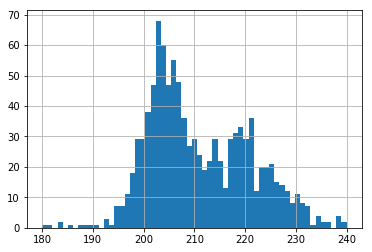

In [10]:
def FindLeadingEdge(e):
    
    event= e.iloc[1:-1]
    grad = np.gradient(event.values)
    peaks = peakdetect(grad,lookahead=10,delta=10)
    pl = peaks[1]+peaks[0]
    pl = [(x,y) for x,y in pl if x>10 and x<500]
    mp = max(zip(*pl)[1])
    pl = [(x,y) for x,y in pl if abs(y)>0.5*mp]
    pp = sorted(pl,key=lambda x:x[1])[-1]
    #print e[['EventID','trigger']].values.tolist() +list(pp)
    tmp = e[['EventID','Edge']].values.tolist() +list(pp)
    return pd.Series(tmp,index=['EventID','trigger','pos','height'])

tmp_df = pd.merge(convol_df,t0_df_72,on='EventID')
tmp_df = tmp_df[~tmp_df['Edge'].isnull()]
tmp_df = tmp_df[(tmp_df['Edge']<425)&(tmp_df['Edge']>350)]
peakdf = tmp_df.apply(FindLeadingEdge,axis=1)
#(peakdf['trigger']-peakdf['pos']).hist(bins=np.linspace(150,200,100))
(peakdf['pos']).hist(bins=np.linspace(180,240,60))

,EventID,trigger,pos,height
0,0.0,380.0,203.0,4100.800056
1,1.0,380.0,273.0,4060.300070
2,2.0,383.0,208.0,3125.799978
3,3.0,379.0,209.0,3011.299930
4,4.0,378.0,207.0,3916.500008
5,5.0,386.0,219.0,1432.099991
6,6.0,381.0,213.0,3485.950015
7,7.0,382.0,221.0,3189.749923
8,8.0,379.0,201.0,3833.100078
10,10.0,381.0,207.0,3775.249937


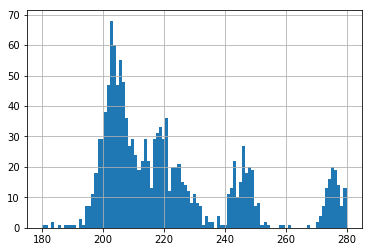

In [11]:
peakdf['pos'].hist(bins = np.linspace(180,280,100))
peakdf[(peakdf['pos']>180)&(peakdf['pos']<280)]

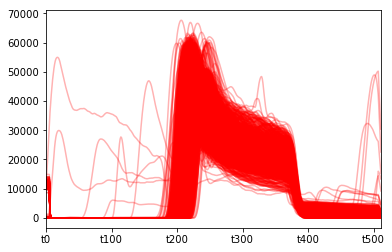

In [12]:
tmp = convol_df.ix[peakdf[(peakdf['pos']>180)&(peakdf['pos']<240)].index]

tmp[tmp.iloc[:,1:].max(axis=1)<70000].iloc[:,1:].T.plot(c=(1,0,0,0.3),legend=False)
